In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import requests
import xml.etree.ElementTree as ET
from ta.trend import ADXIndicator
from ta.momentum import StochasticOscillator


In [2]:
df_SBER_daily = pd.read_csv("SBER_daily.csv")
df_SBER_daily.columns

Index(['ticker', 'Open', 'Close', 'High', 'Low', 'value', 'Volume', 'Date',
       'end', 'SMA_10', 'EMA_10', 'SMA_50', 'EMA_50', 'MACD', 'MACD_signal',
       'MACD_diff', 'ATR_14', 'OBV', 'VWAP', 'rolling_std_20', 'USD_RUB',
       'Brent', 'Inflation', 'RSI', 'DailyReturn', 'ADX_14', 'Stoch_%K',
       'Stoch_%D', 'RSI_lag1', 'RSI_lag2', 'Price_deviation_SMA50', 'SMA_20',
       'RollingStd_20', 'Bollinger_BandWidth', 'VWAP_deviation', 'RSI_slope',
       'Williams_%R', 'RelativeVolume'],
      dtype='object')

In [3]:

tickers = [
    'AFLT', 'ALRS', 'CHMF', 'GAZP', 'GMKN',
    'LKOH', 'MGNT', 'MOEX', 'MTSS', 'NVTK',
    'ROSN', 'SBER', 'TATN', 'VTBR', 'YNDX'
]


cluster2_tickers = ['AFLT', 'ALRS', 'GAZP', 'GMKN', 'MOEX', 'MTSS', 'SBER', 'VTBR']
other_tickers = [t for t in tickers if t not in cluster2_tickers]

daily_dir = "datasets_daily"
hourly_dir = "datasets_hourly"

for ticker in other_tickers:
    daily_path = os.path.join(daily_dir, f"dataset_{ticker}_daily.csv")
    hourly_path = os.path.join(hourly_dir, f"dataset_{ticker}_hourly.csv")

    if os.path.exists(daily_path):
        globals()[f"df_{ticker}_daily"] = pd.read_csv(daily_path)
        print(f"[✓] Загружен df_{ticker}_daily из {daily_path}")
    else:
        print(f"[✗] Не найден файл: {daily_path}")
    

    
    if os.path.exists(hourly_path):
        globals()[f"df_{ticker}_hourly"] = pd.read_csv(hourly_path)
        print(f"[✓] Загружен df_{ticker}_hourly из {hourly_path}")
    else:
        print(f"[✗] Не найден файл: {hourly_path}")


[✓] Загружен df_CHMF_daily из datasets_daily/dataset_CHMF_daily.csv
[✓] Загружен df_CHMF_hourly из datasets_hourly/dataset_CHMF_hourly.csv
[✓] Загружен df_LKOH_daily из datasets_daily/dataset_LKOH_daily.csv
[✓] Загружен df_LKOH_hourly из datasets_hourly/dataset_LKOH_hourly.csv
[✓] Загружен df_MGNT_daily из datasets_daily/dataset_MGNT_daily.csv
[✓] Загружен df_MGNT_hourly из datasets_hourly/dataset_MGNT_hourly.csv
[✓] Загружен df_NVTK_daily из datasets_daily/dataset_NVTK_daily.csv
[✓] Загружен df_NVTK_hourly из datasets_hourly/dataset_NVTK_hourly.csv
[✓] Загружен df_ROSN_daily из datasets_daily/dataset_ROSN_daily.csv
[✓] Загружен df_ROSN_hourly из datasets_hourly/dataset_ROSN_hourly.csv
[✓] Загружен df_TATN_daily из datasets_daily/dataset_TATN_daily.csv
[✓] Загружен df_TATN_hourly из datasets_hourly/dataset_TATN_hourly.csv
[✓] Загружен df_YNDX_daily из datasets_daily/dataset_YNDX_daily.csv
[✓] Загружен df_YNDX_hourly из datasets_hourly/dataset_YNDX_hourly.csv


In [4]:

def compute_sma_slope(series, window=5):
    def slope(x):
        if np.isnan(x).any():
            return np.nan
        return np.polyfit(np.arange(len(x)), x, 1)[0]
    return series.rolling(window=window, min_periods=window).apply(slope, raw=True)

# Функция для расчета RSI
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Функция для расчета Williams %R
def compute_williams_r(df, window=14):
    highest = df['High'].rolling(window=window, min_periods=window).max()
    lowest = df['Low'].rolling(window=window, min_periods=window).min()
    return -100 * (highest - df['Close']) / (highest - lowest)


# Функция для добавления признаков в датасет
def add_features(df, freq='daily'):
    # 1. EMA_diff
    if 'EMA_diff' not in df.columns:
        if 'EMA_10' in df.columns and 'EMA_50' in df.columns:
            df['EMA_diff'] = df['EMA_10'] - df['EMA_50']
    
    # 2. RSI_Stoch_diff
    if 'RSI_Stoch_diff' not in df.columns:
        if 'RSI' in df.columns and 'Stoch_%D' in df.columns:
            df['RSI_Stoch_diff'] = df['RSI'] - df['Stoch_%D']
    
    # 3. SMA_20_slope
    if 'SMA_20_slope' not in df.columns:
        if 'SMA_20' not in df.columns:
            df['SMA_20'] = df['Close'].rolling(window=20, min_periods=20).mean()
        df['SMA_20_slope'] = compute_sma_slope(df['SMA_20'], window=5)
    
    # 4. DailyRange / Price_deviation_SMA50
    if 'DailyRange' not in df.columns and 'High' in df.columns and 'Low' in df.columns and 'SMA_50' in df.columns:
        df['DailyRange'] = (df['High'] - df['Low']) / df['SMA_50']
    
    # 5. Return_vs_VWAP
    if 'Return_vs_VWAP' not in df.columns and 'DailyReturn' in df.columns and 'VWAP_deviation' in df.columns:
        df['Return_vs_VWAP'] = df['DailyReturn'] - df['VWAP_deviation']
    
    # 6. RelativeVolume_change / RelativeVolume
    if 'RelativeVolume_change' not in df.columns and 'RelativeVolume' in df.columns:
        df['RelativeVolume_change'] = df['RelativeVolume'].diff()
    
    if freq == 'hourly':
        # Часовые признаки
        # 1. RSI, если отсутствует
        if 'RSI' not in df.columns:
            df['RSI'] = 100 - (100 / (1 + 
                (df['Close'].diff().clip(lower=0).rolling(window=14, min_periods=14).mean() /
                 df['Close'].diff().clip(upper=0).abs().rolling(window=14, min_periods=14).mean())
            ))

        # 2. RSI_lag1 и RSI_lag2
        if 'RSI_lag1_hourly' not in df.columns:
            df['RSI_lag1_hourly'] = df['RSI'].shift(1)
        if 'RSI_lag2_hourly' not in df.columns:
            df['RSI_lag2_hourly'] = df['RSI'].shift(2)

        # 3. Stoch_%D_hourly, если отсутствует
        if 'Stoch_%D_hourly' not in df.columns and 'Stoch_%K' in df.columns:
            df['Stoch_%D_hourly'] = df['Stoch_%K'].rolling(window=3, min_periods=3).mean()

        # 4. Williams_%R_hourly
        if 'Williams_%R_hourly' not in df.columns:
            df['Williams_%R_hourly'] = compute_williams_r(df, window=14)
        
        # 5. Price_deviation_SMA50_hourly
        if 'Price_deviation_SMA50_hourly' not in df.columns:
            if 'SMA_50' not in df.columns:
                df['SMA_50'] = df['Close'].rolling(window=50, min_periods=50).mean()
            df['Price_deviation_SMA50_hourly'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
        
        # 6. RSI_slope_hourly
        if 'RSI_slope_hourly' not in df.columns:
            df['RSI_slope_hourly'] = compute_sma_slope(df['RSI'], window=5)
        
        # 7. HourlyReturn
        if 'HourlyReturn' not in df.columns:
            df['HourlyReturn'] = df['Close'].pct_change()
        
        # 8. Momentum_5_hourly
        if 'Momentum_5_hourly' not in df.columns:
            df['Momentum_5_hourly'] = (df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)
        
        # 9. RollingVol_10_hourly
        if 'RollingVol_10_hourly' not in df.columns:
            df['RollingVol_10_hourly'] = df['HourlyReturn'].rolling(window=10, min_periods=10).std()
        
        # 10. RelativeVolume_hourly
        if 'RelativeVolume_hourly' not in df.columns:
            df['Volume_SMA20_hourly'] = df['Volume'].rolling(window=20, min_periods=20).mean()
            df['RelativeVolume_hourly'] = df['Volume'] / df['Volume_SMA20_hourly']
    
    return df

# --- ОБРАБОТКА ДНЕВНЫХ И ЧАСОВЫХ ДАТАСЕТОВ ---


other_tickers = ['CHMF', 'LKOH', 'MGNT', 'NVTK', 'ROSN', 'TATN', 'YNDX']

for ticker in other_tickers:

    var_daily = f"df_{ticker}_daily"
    if var_daily in globals():
        df_daily = globals()[var_daily].copy()
        df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')
        df_daily = df_daily.sort_values('Date').reset_index(drop=True)
        if 'ticker' not in df_daily.columns:
            df_daily['ticker'] = ticker

        df_daily = add_features(df_daily, freq='daily')
        
        globals()[var_daily] = df_daily
        print(f"{ticker} daily dataset updated with additional features. Shape: {df_daily.shape}")


    var_hourly = f"df_{ticker}_hourly"
    if var_hourly in globals():
        df_hourly = globals()[var_hourly].copy()
        df_hourly['Date'] = pd.to_datetime(df_hourly['Date'], errors='coerce')
        df_hourly = df_hourly.sort_values('Date').reset_index(drop=True)
        if 'ticker' not in df_hourly.columns:
            df_hourly['ticker'] = ticker
        

        df_hourly = add_features(df_hourly, freq='hourly')
        
        globals()[var_hourly] = df_hourly
        print(f"{ticker} hourly dataset updated with additional features. Shape: {df_hourly.shape}")


CHMF daily dataset updated with additional features. Shape: (4491, 27)
CHMF hourly dataset updated with additional features. Shape: (27804, 35)
LKOH daily dataset updated with additional features. Shape: (4491, 27)
LKOH hourly dataset updated with additional features. Shape: (27804, 35)
MGNT daily dataset updated with additional features. Shape: (4491, 27)
MGNT hourly dataset updated with additional features. Shape: (27804, 35)
NVTK daily dataset updated with additional features. Shape: (4491, 27)
NVTK hourly dataset updated with additional features. Shape: (27804, 35)
ROSN daily dataset updated with additional features. Shape: (4491, 27)
ROSN hourly dataset updated with additional features. Shape: (27804, 35)
TATN daily dataset updated with additional features. Shape: (4491, 27)
TATN hourly dataset updated with additional features. Shape: (27804, 35)
YNDX daily dataset updated with additional features. Shape: (2364, 27)
YNDX hourly dataset updated with additional features. Shape: (278

In [1]:
df_YNDX_hourly.columns

NameError: name 'df_YNDX_hourly' is not defined

In [6]:
import os
import numpy as np
import pandas as pd

# === Параметры ===
other_tickers = ['CHMF', 'LKOH', 'MGNT', 'NVTK', 'ROSN', 'TATN', 'YNDX']
daily_dir = "datasets_daily"
hourly_dir = "datasets_hourly"


def compute_sma_slope(series, window=5):
    def slope(x):
        if np.isnan(x).any():
            return np.nan
        return np.polyfit(np.arange(len(x)), x, 1)[0]
    return series.rolling(window=window, min_periods=window).apply(slope, raw=True)


def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))


def compute_williams_r(df, window=14):
    highest = df['High'].rolling(window=window, min_periods=window).max()
    lowest = df['Low'].rolling(window=window, min_periods=window).min()
    return -100 * (highest - df['Close']) / (highest - lowest)


# === Универсальная функция добавления признаков ===
def enrich_dataset(df, freq):
    df = df.copy()
    
    # EMA_diff
    if 'EMA_diff' not in df.columns and 'EMA_10' in df.columns and 'EMA_50' in df.columns:
        df['EMA_diff'] = df['EMA_10'] - df['EMA_50']
    
    # RSI
    if 'RSI' not in df.columns:
        df['RSI'] = compute_RSI(df['Close'], window=14)
    
    # RSI_Stoch_diff
    if 'RSI_Stoch_diff' not in df.columns and 'RSI' in df.columns and 'Stoch_%D' in df.columns:
        df['RSI_Stoch_diff'] = df['RSI'] - df['Stoch_%D']
    
    # SMA_20 и наклон
    if 'SMA_20' not in df.columns:
        df['SMA_20'] = df['Close'].rolling(window=20, min_periods=20).mean()
    if 'SMA_20_slope' not in df.columns:
        df['SMA_20_slope'] = compute_sma_slope(df['SMA_20'], window=5)
    
    # SMA_50 и Price deviation
    if 'SMA_50' not in df.columns:
        df['SMA_50'] = df['Close'].rolling(window=50, min_periods=50).mean()
    if freq == 'hourly' and 'Price_deviation_SMA50_hourly' not in df.columns:
        df['Price_deviation_SMA50_hourly'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    if freq == 'daily' and 'DailyRange' not in df.columns and all(c in df.columns for c in ['High','Low','SMA_50']):
        df['DailyRange'] = (df['High'] - df['Low']) / df['SMA_50']
    
    # RSI lag
    if freq == 'hourly':
        if 'RSI_lag1_hourly' not in df.columns:
            df['RSI_lag1_hourly'] = df['RSI'].shift(1)
        if 'RSI_lag2_hourly' not in df.columns:
            df['RSI_lag2_hourly'] = df['RSI'].shift(2)
    
    # Stochastic D
    if freq == 'hourly' and 'Stoch_%D_hourly' not in df.columns and 'Stoch_%K' in df.columns:
        df['Stoch_%D_hourly'] = df['Stoch_%K'].rolling(window=3, min_periods=3).mean()

    # Williams %R
    if freq == 'hourly' and 'Williams_%R_hourly' not in df.columns:
        df['Williams_%R_hourly'] = compute_williams_r(df, window=14)

    # RSI slope
    rsi_slope_col = 'RSI_slope_hourly' if freq == 'hourly' else 'RSI_slope_daily'
    if rsi_slope_col not in df.columns:
        df[rsi_slope_col] = compute_sma_slope(df['RSI'], window=5)

    # Return
    return_col = 'HourlyReturn' if freq == 'hourly' else 'DailyReturn'
    if return_col not in df.columns:
        df[return_col] = df['Close'].pct_change()
    
    # Momentum
    mom_col = 'Momentum_5_hourly' if freq == 'hourly' else 'Momentum_5_daily'
    if mom_col not in df.columns:
        df[mom_col] = (df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)
    
    # RollingVol
    vol_col = 'RollingVol_10_hourly' if freq == 'hourly' else 'RollingVol_10_daily'
    if vol_col not in df.columns:
        df[vol_col] = df[return_col].rolling(window=10, min_periods=10).std()
    
    # RelativeVolume
    vol_sma_col = 'Volume_SMA20_hourly' if freq == 'hourly' else 'Volume_SMA20_daily'
    rel_vol_col = 'RelativeVolume_hourly' if freq == 'hourly' else 'RelativeVolume_daily'
    if rel_vol_col not in df.columns:
        df[vol_sma_col] = df['Volume'].rolling(window=20, min_periods=20).mean()
        df[rel_vol_col] = df['Volume'] / df[vol_sma_col]

    # Изменение объема
    if freq == 'daily' and 'RelativeVolume_change' not in df.columns and 'RelativeVolume' in df.columns:
        df['RelativeVolume_change'] = df['RelativeVolume'].diff()
    
    # Возврат против VWAP
    if freq == 'daily' and 'Return_vs_VWAP' not in df.columns and 'DailyReturn' in df.columns and 'VWAP_deviation' in df.columns:
        df['Return_vs_VWAP'] = df['DailyReturn'] - df['VWAP_deviation']
    
    return df



for ticker in other_tickers:
    # DAILY
    daily_path = os.path.join(daily_dir, f"dataset_{ticker}_daily.csv")
    if os.path.exists(daily_path):
        df_daily = pd.read_csv(daily_path)
        df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')
        df_daily = df_daily.sort_values('Date').reset_index(drop=True)
        if 'ticker' not in df_daily.columns:
            df_daily['ticker'] = ticker
        df_daily = enrich_dataset(df_daily, freq='daily')
        globals()[f"df_{ticker}_daily"] = df_daily
        print(f"{ticker} daily dataset updated. Shape: {df_daily.shape}")
    else:
        print(f"{ticker} daily file not found.")

    # HOURLY
    hourly_path = os.path.join(hourly_dir, f"dataset_{ticker}_hourly.csv")
    if os.path.exists(hourly_path):
        df_hourly = pd.read_csv(hourly_path)
        df_hourly['Date'] = pd.to_datetime(df_hourly['Date'], errors='coerce')
        df_hourly = df_hourly.sort_values('Date').reset_index(drop=True)
        if 'ticker' not in df_hourly.columns:
            df_hourly['ticker'] = ticker
        df_hourly = enrich_dataset(df_hourly, freq='hourly')
        globals()[f"df_{ticker}_hourly"] = df_hourly
        print(f"{ticker} hourly dataset updated. Shape: {df_hourly.shape}")
    else:
        print(f"{ticker} hourly file not found.")


CHMF daily dataset updated. Shape: (4491, 34)
CHMF hourly dataset updated. Shape: (27804, 34)
LKOH daily dataset updated. Shape: (4491, 34)
LKOH hourly dataset updated. Shape: (27804, 34)
MGNT daily dataset updated. Shape: (4491, 34)
MGNT hourly dataset updated. Shape: (27804, 34)
NVTK daily dataset updated. Shape: (4491, 34)
NVTK hourly dataset updated. Shape: (27804, 34)
ROSN daily dataset updated. Shape: (4491, 34)
ROSN hourly dataset updated. Shape: (27804, 34)
TATN daily dataset updated. Shape: (4491, 34)
TATN hourly dataset updated. Shape: (27804, 34)
YNDX daily dataset updated. Shape: (2364, 34)
YNDX hourly dataset updated. Shape: (27804, 34)



CHMF daily корреляции с RSI (|corr| >= 0.3):
SMA_20_slope        0.536797
MACD                0.532797
Momentum_5_daily    0.471620
MACD_diff           0.466746
EMA_diff            0.456476
MACD_signal         0.431537
RSI_slope_daily     0.422105
Name: RSI, dtype: float64


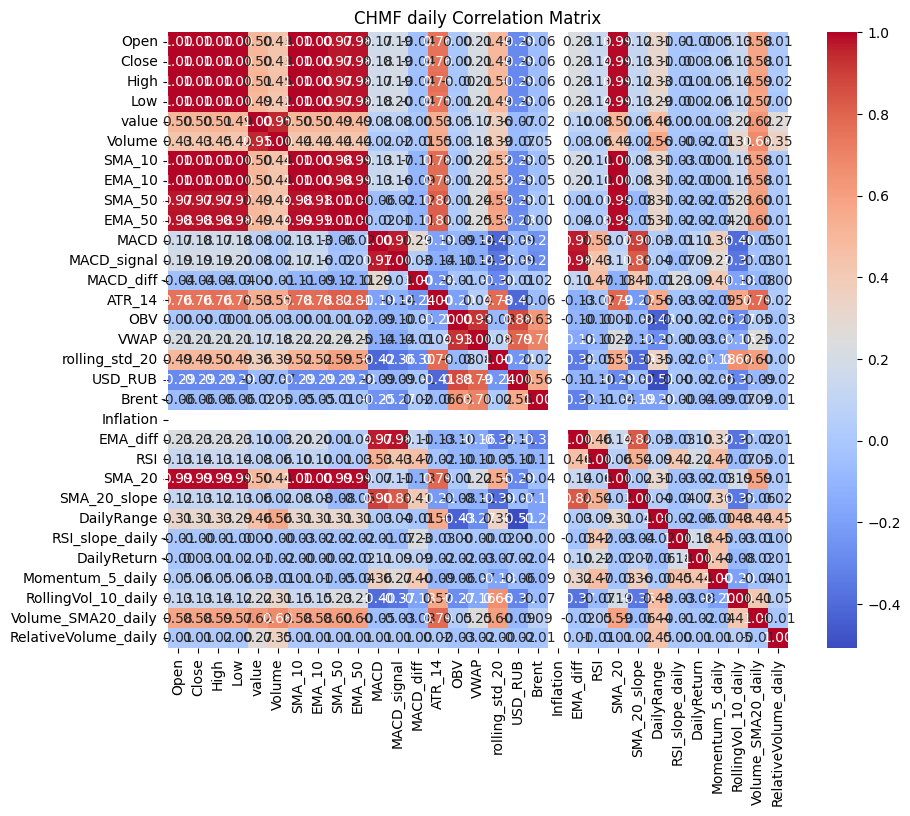


LKOH daily корреляции с RSI (|corr| >= 0.3):
MACD                0.526690
MACD_diff           0.521329
SMA_20_slope        0.496883
Momentum_5_daily    0.444436
EMA_diff            0.439097
RSI_slope_daily     0.430060
MACD_signal         0.400924
Name: RSI, dtype: float64


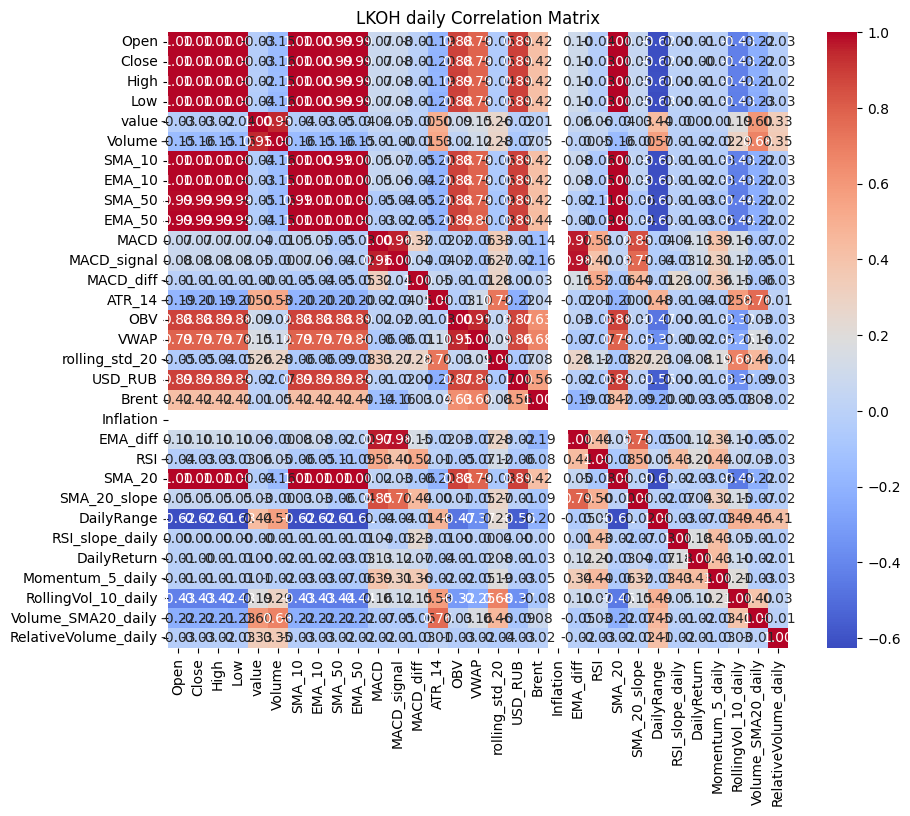


MGNT daily корреляции с RSI (|corr| >= 0.3):
MACD                0.566595
MACD_diff           0.541944
SMA_20_slope        0.533542
EMA_diff            0.473295
Momentum_5_daily    0.460825
MACD_signal         0.441470
RSI_slope_daily     0.430813
Name: RSI, dtype: float64


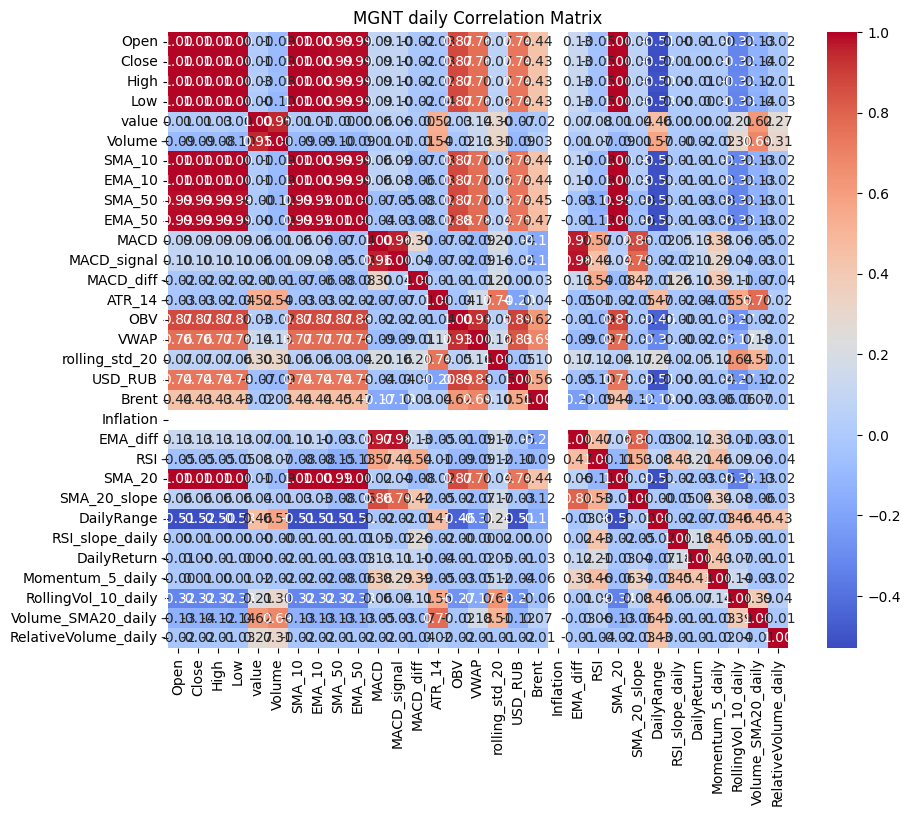


NVTK daily корреляции с RSI (|corr| >= 0.3):
MACD                0.487615
SMA_20_slope        0.483011
Momentum_5_daily    0.449837
MACD_diff           0.434904
RSI_slope_daily     0.426734
EMA_diff            0.420160
MACD_signal         0.389079
Name: RSI, dtype: float64


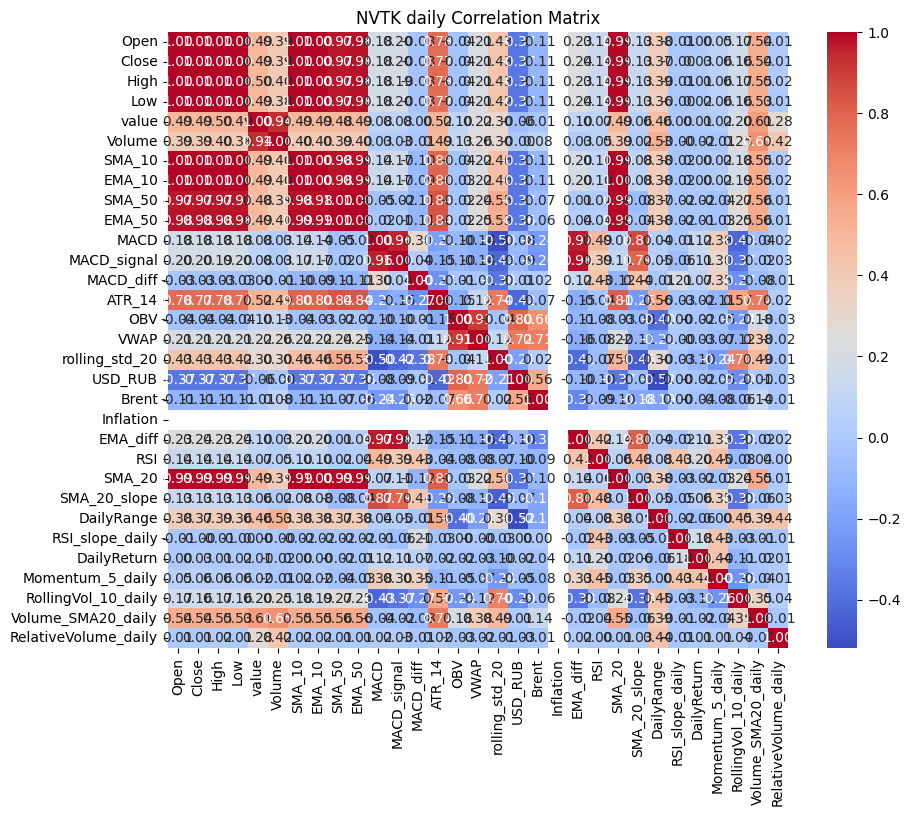


ROSN daily корреляции с RSI (|corr| >= 0.3):
MACD                0.466674
SMA_20_slope        0.462730
Momentum_5_daily    0.436411
RSI_slope_daily     0.421628
EMA_diff            0.408604
MACD_diff           0.392845
MACD_signal         0.377868
Name: RSI, dtype: float64


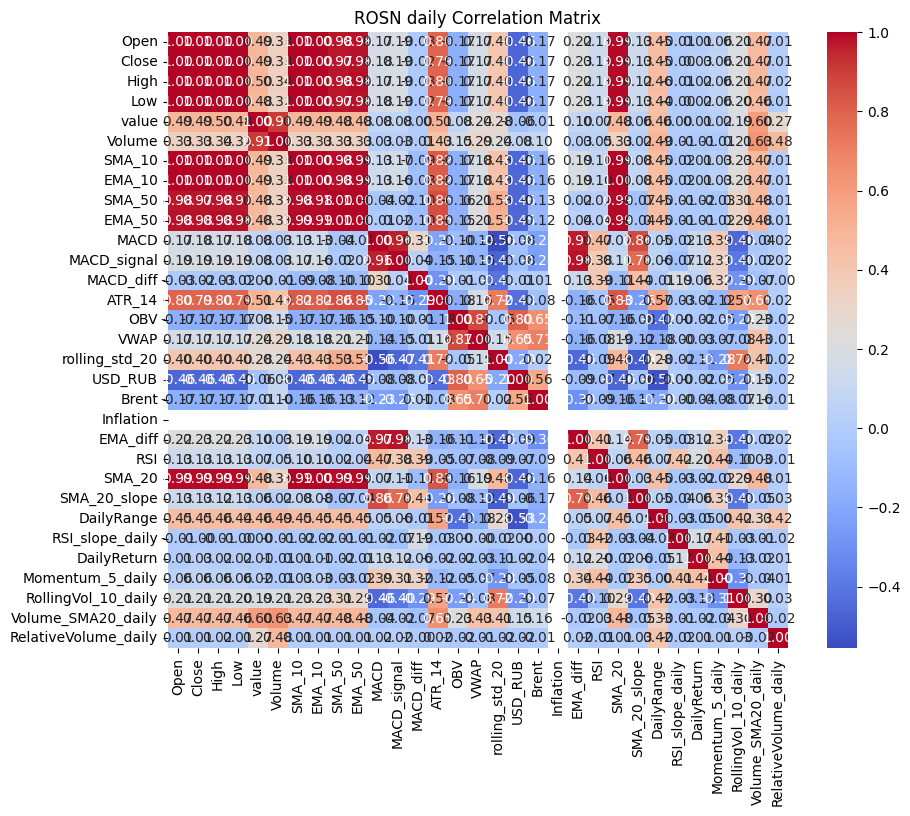


TATN daily корреляции с RSI (|corr| >= 0.3):
MACD                0.473170
SMA_20_slope        0.466870
Momentum_5_daily    0.445613
MACD_diff           0.416174
RSI_slope_daily     0.413199
EMA_diff            0.409744
MACD_signal         0.378274
Name: RSI, dtype: float64


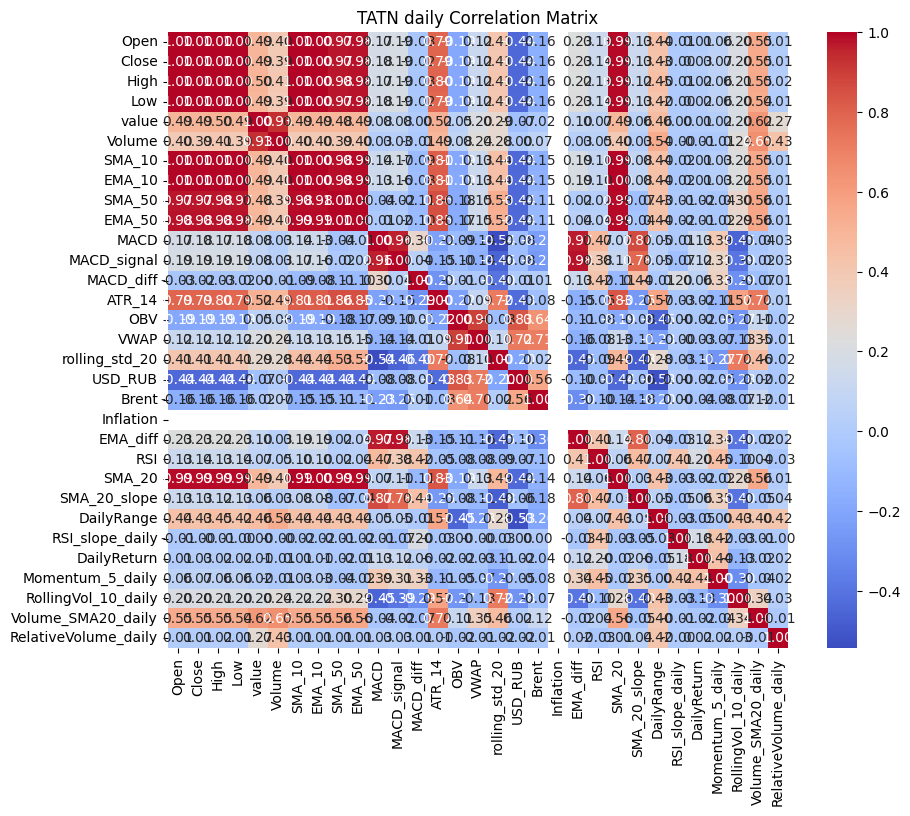


YNDX daily корреляции с RSI (|corr| >= 0.3):
SMA_20_slope        0.627011
MACD_diff           0.613330
MACD                0.610375
Momentum_5_daily    0.528832
EMA_diff            0.507189
MACD_signal         0.476439
RSI_slope_daily     0.379692
Name: RSI, dtype: float64


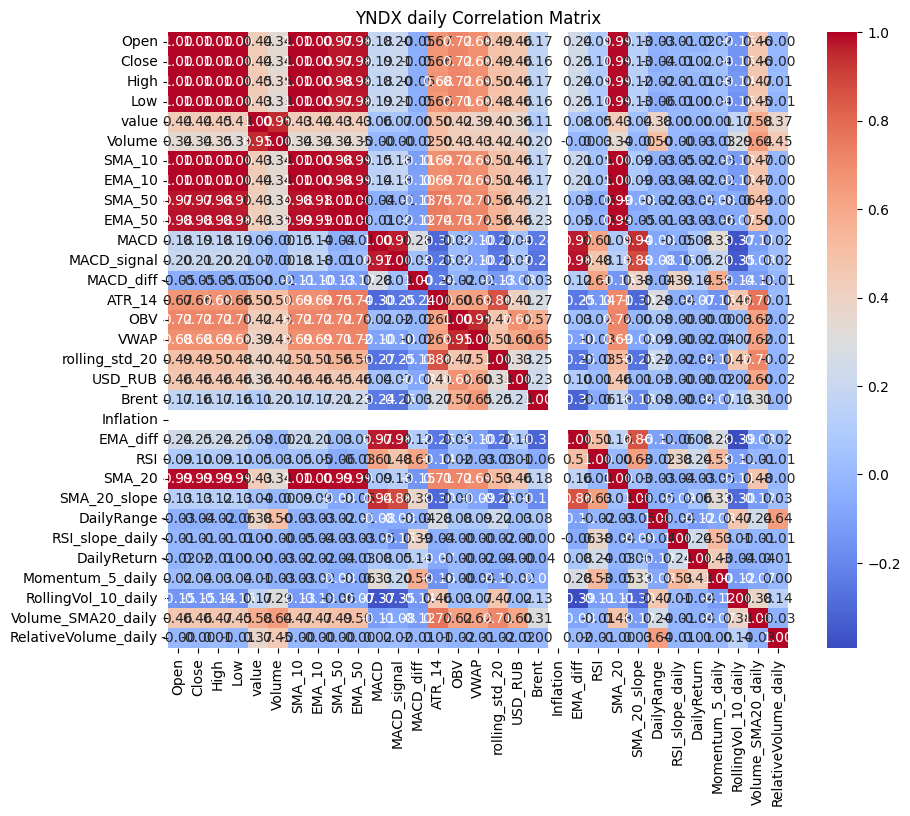


CHMF hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


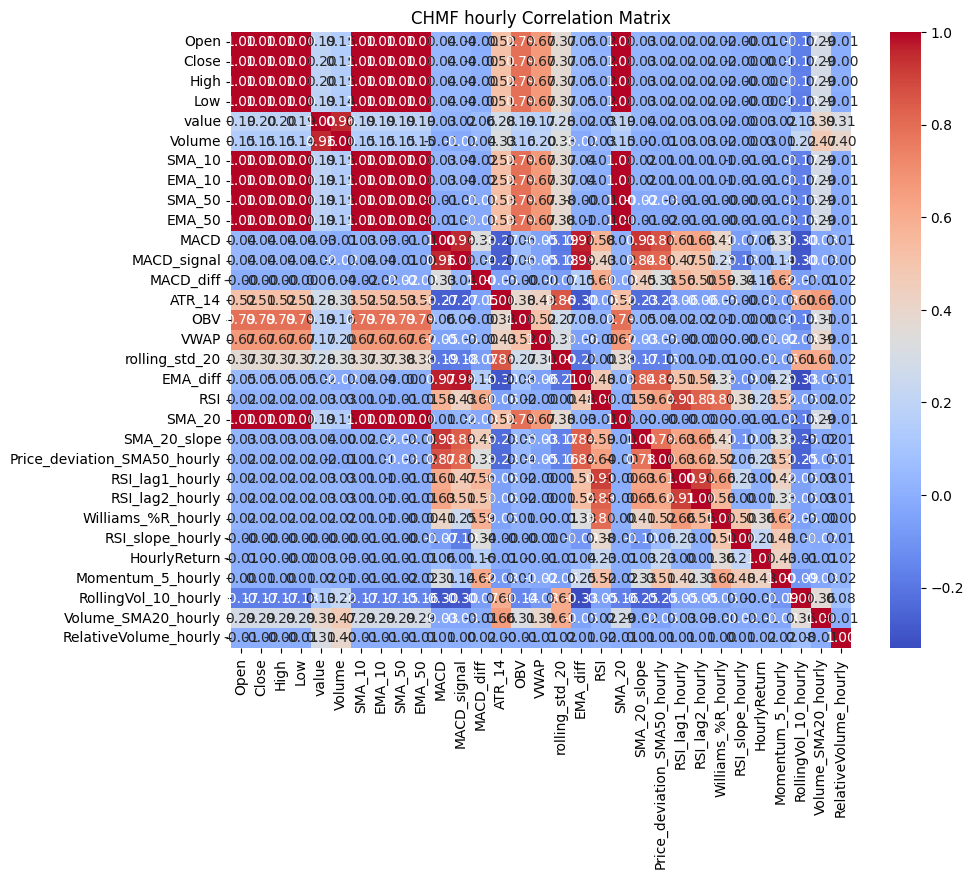


LKOH hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


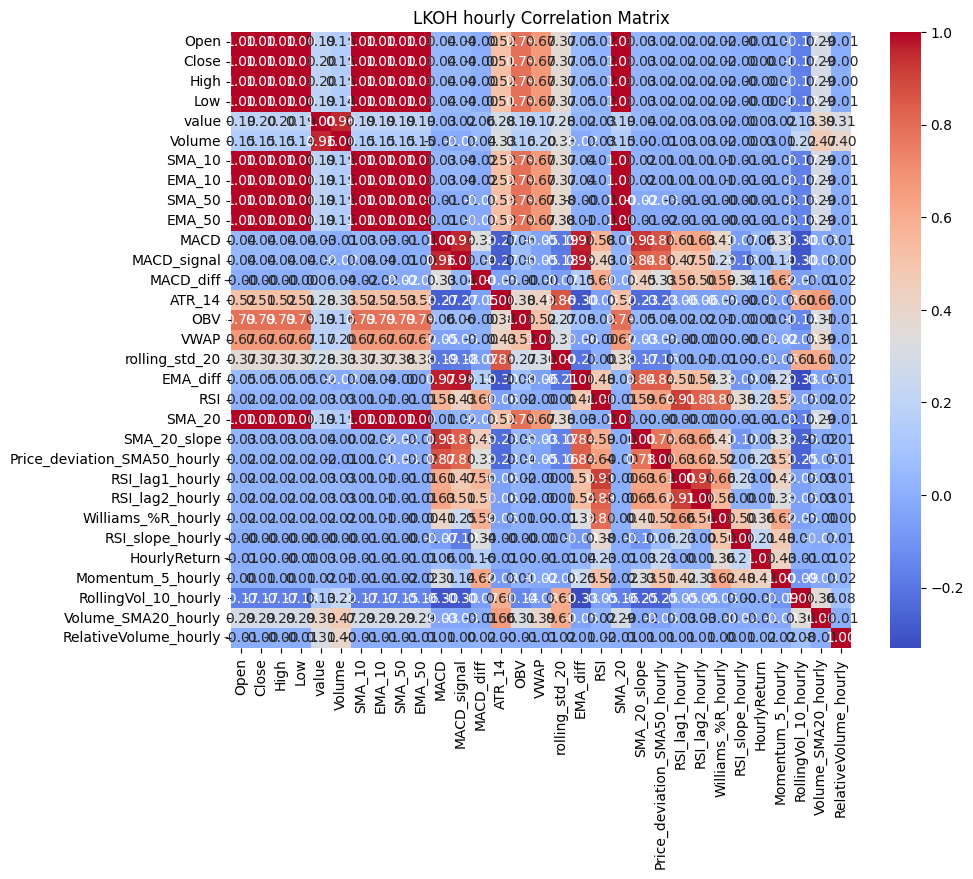


MGNT hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


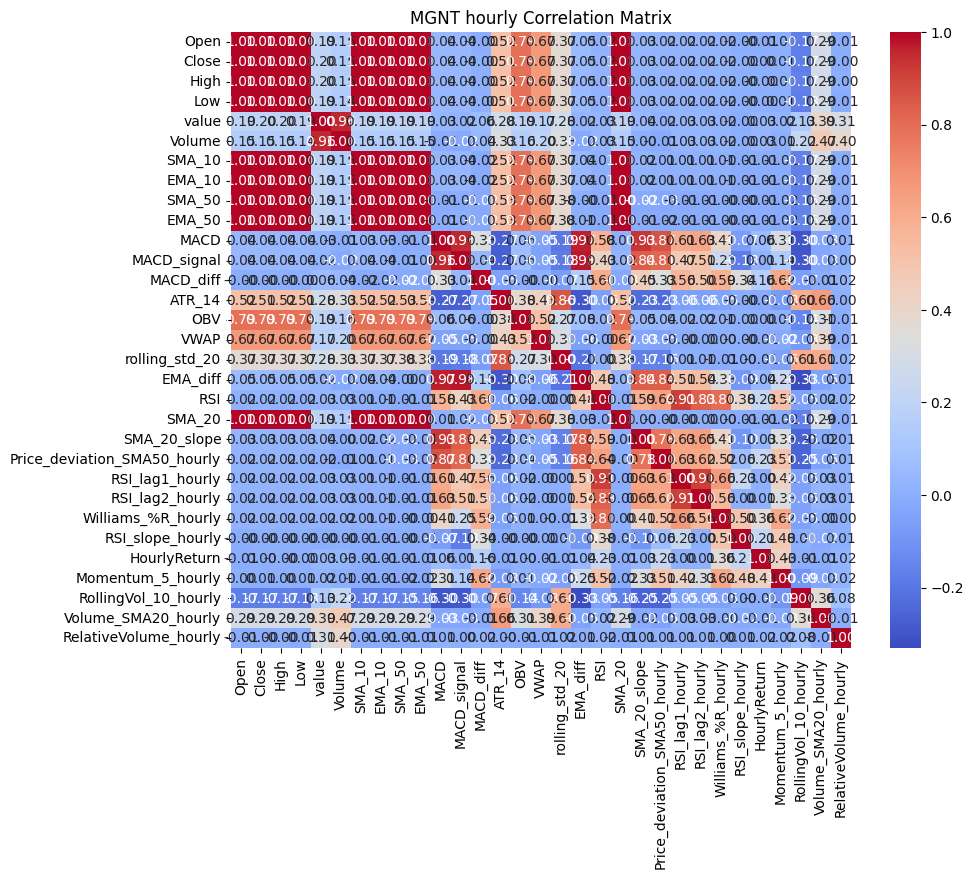


NVTK hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


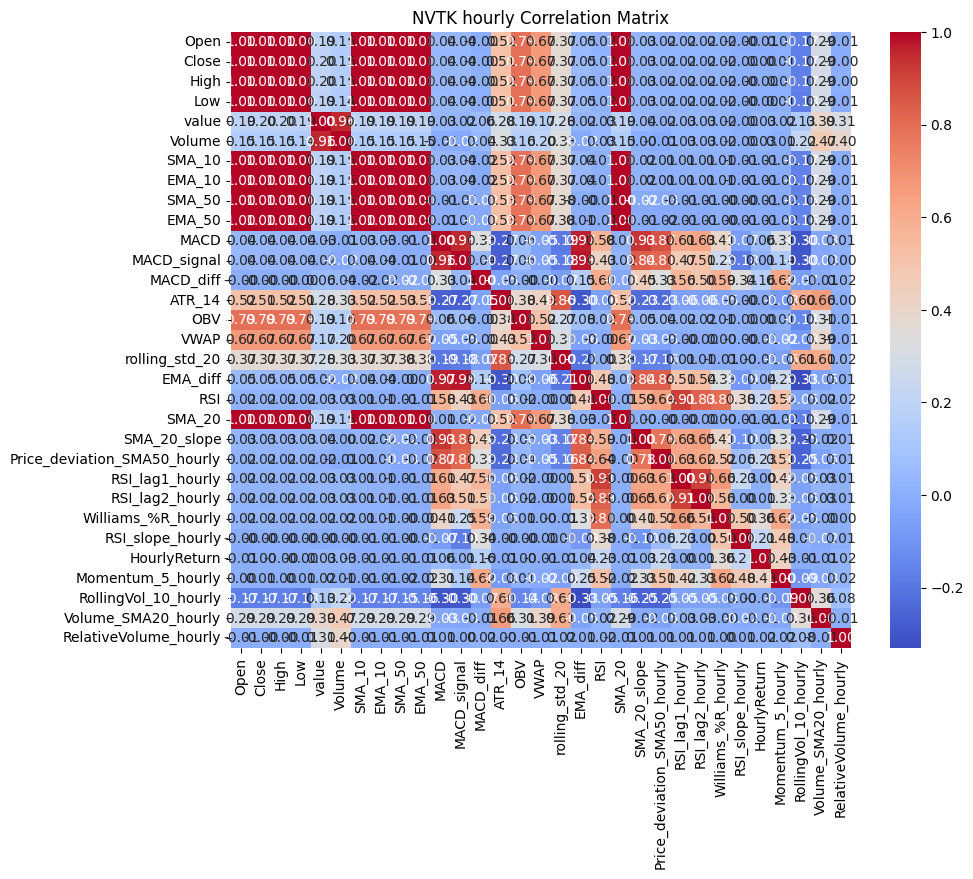


ROSN hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


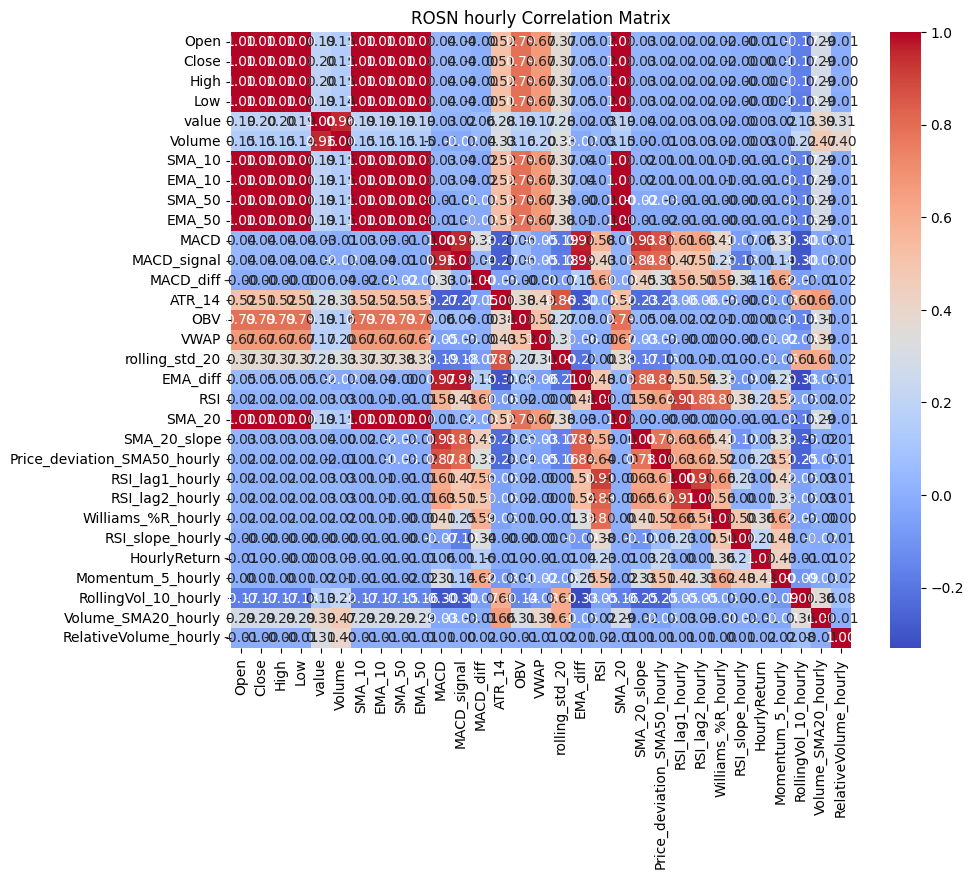


TATN hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


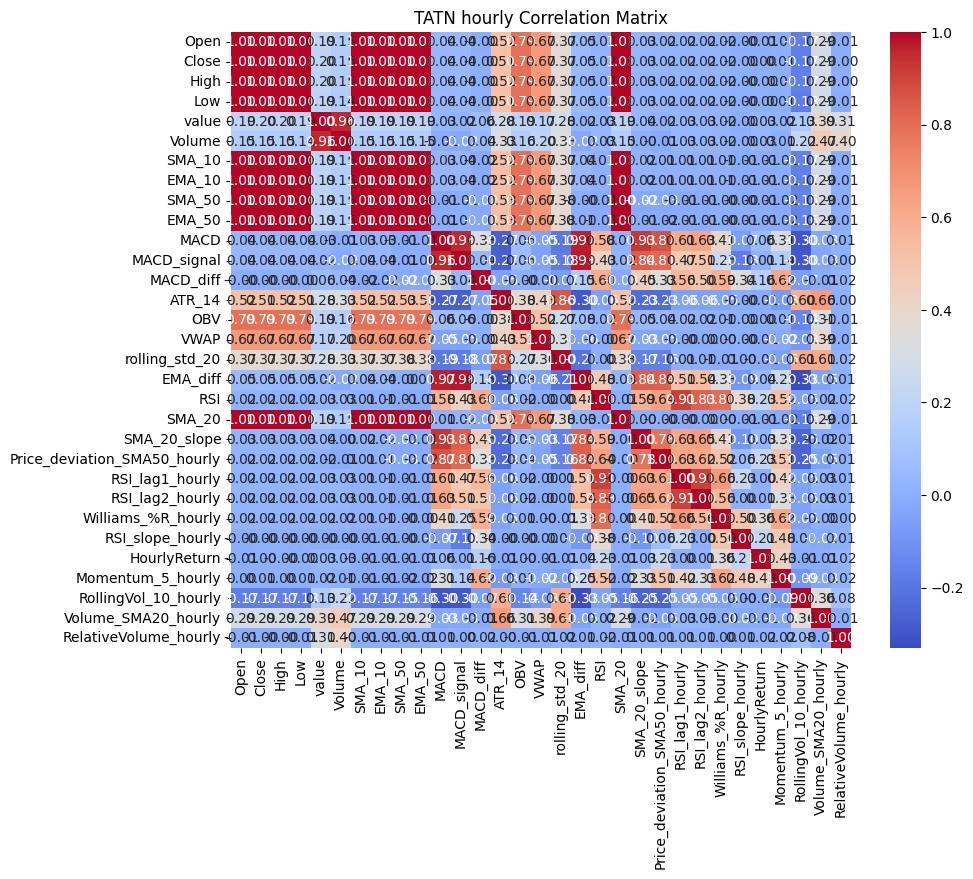


YNDX hourly корреляции с RSI (|corr| >= 0.3):
RSI_lag1_hourly                 0.910650
RSI_lag2_hourly                 0.832931
Williams_%R_hourly              0.800154
Price_deviation_SMA50_hourly    0.643302
MACD_diff                       0.601002
SMA_20_slope                    0.585699
MACD                            0.578816
Momentum_5_hourly               0.517556
EMA_diff                        0.484396
MACD_signal                     0.426346
RSI_slope_hourly                0.384873
Name: RSI, dtype: float64


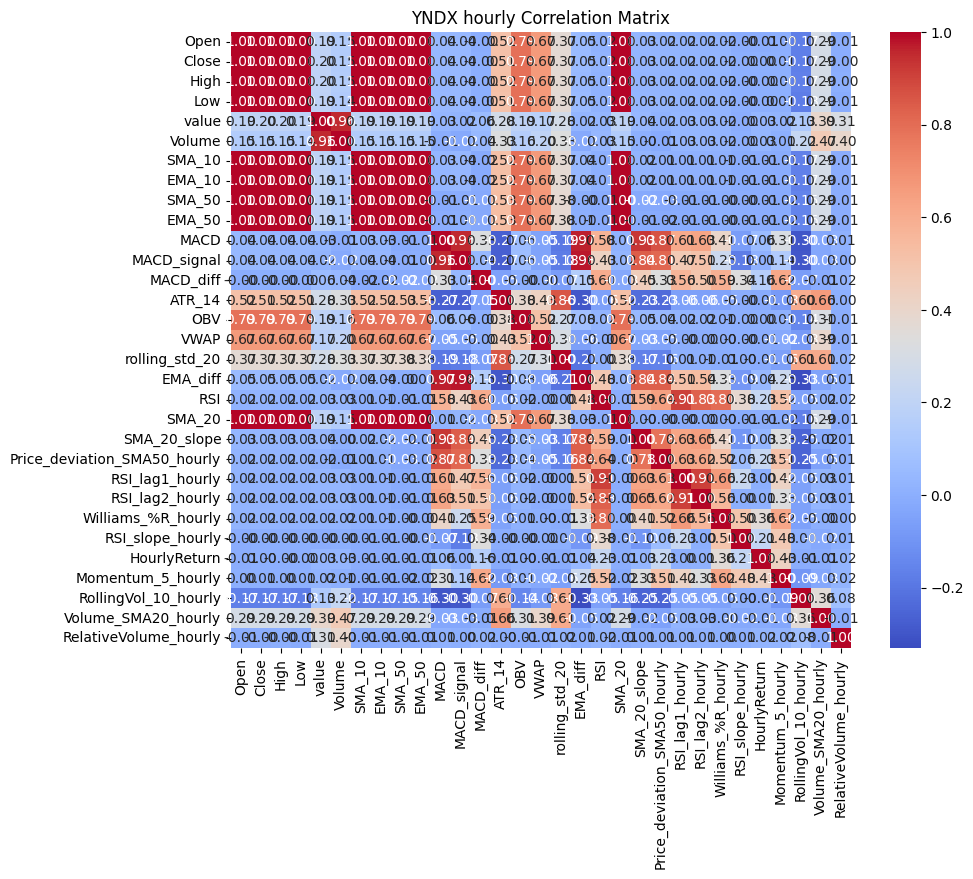

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def print_rsi_correlations(df, dataset_type, ticker, threshold=0.3):

    numeric_df = df.select_dtypes(include=[np.number])
    if 'RSI' not in numeric_df.columns:
        print(f"{ticker} {dataset_type} dataset не содержит столбца RSI.")
        return
    # Вычисляем корреляционную матрицу
    corr_matrix = numeric_df.corr()
    # Извлекаем корреляции с RSI (исключая сам RSI)
    rsi_corr = corr_matrix['RSI'].drop('RSI')
    strong_corr = rsi_corr[abs(rsi_corr) >= threshold]
    
    print(f"\n{ticker} {dataset_type} корреляции с RSI (|corr| >= {threshold}):")
    print(strong_corr.sort_values(key=abs, ascending=False))
    
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{ticker} {dataset_type} Correlation Matrix")
    plt.show()


other_tickers = ['CHMF', 'LKOH', 'MGNT', 'NVTK', 'ROSN', 'TATN', 'YNDX']


for ticker in other_tickers:
    var_daily = f"df_{ticker}_daily"
    if var_daily in globals():
        df_daily = globals()[var_daily].copy()
        # Приводим Date к datetime (если еще не сделано) и сортируем по дате
        df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')
        df_daily.sort_values('Date', inplace=True)
        print_rsi_correlations(df_daily, "daily", ticker)
    else:
        print(f"{ticker} дневной датасет не найден.")


for ticker in other_tickers:
    var_hourly = f"df_{ticker}_hourly"
    if var_hourly in globals():
        df_hourly = globals()[var_hourly].copy()
        # Приводим Date к datetime и сортируем по дате
        df_hourly['Date'] = pd.to_datetime(df_hourly['Date'], errors='coerce')
        df_hourly.sort_values('Date', inplace=True)
        print_rsi_correlations(df_hourly, "hourly", ticker)
    else:
        print(f"{ticker} часовой датасет не найден.")


In [8]:
df_YNDX_daily.columns

Index(['ticker', 'Open', 'Close', 'High', 'Low', 'value', 'Volume', 'Date',
       'end', 'SMA_10', 'EMA_10', 'SMA_50', 'EMA_50', 'MACD', 'MACD_signal',
       'MACD_diff', 'ATR_14', 'OBV', 'VWAP', 'rolling_std_20', 'USD_RUB',
       'Brent', 'Inflation', 'EMA_diff', 'RSI', 'SMA_20', 'SMA_20_slope',
       'DailyRange', 'RSI_slope_daily', 'DailyReturn', 'Momentum_5_daily',
       'RollingVol_10_daily', 'Volume_SMA20_daily', 'RelativeVolume_daily'],
      dtype='object')

CHMF daily dataset: RSI recomputed.

Корреляции признаков с RSI:
MACD                    0.519966
SMA_20_slope            0.507974
Momentum_5_daily        0.459667
EMA_diff                0.446728
MACD_diff               0.446612
MACD_signal             0.423511
RSI_slope_daily         0.322051
DailyReturn             0.219393
Close                   0.143392
Low                     0.141159
High                    0.138120
Open                    0.136293
USD_RUB                -0.113589
OBV                    -0.110372
Brent                  -0.106839
EMA_10                  0.104904
SMA_10                  0.102790
VWAP                   -0.102437
DailyRange              0.098011
value                   0.079855
Volume                  0.066110
RollingVol_10_daily    -0.064140
SMA_20                  0.063129
Volume_SMA20_daily      0.055212
rolling_std_20         -0.050432
EMA_50                  0.034760
SMA_50                  0.013417
RelativeVolume_daily   -0.007707
ATR_14     

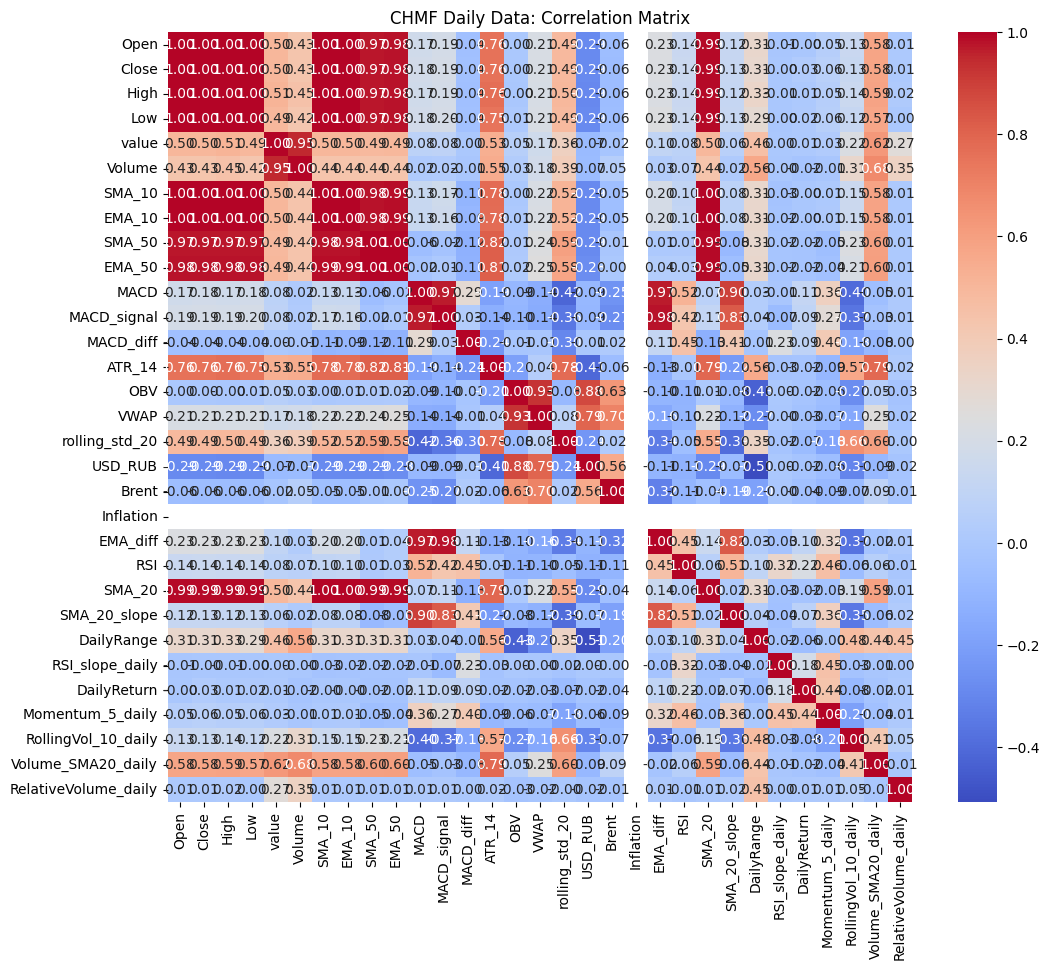

CHMF daily dataset: 'Inflation' removed. New shape: (4491, 33)
LKOH daily dataset: 'Inflation' removed. New shape: (4491, 33)
MGNT daily dataset: 'Inflation' removed. New shape: (4491, 33)
NVTK daily dataset: 'Inflation' removed. New shape: (4491, 33)
ROSN daily dataset: 'Inflation' removed. New shape: (4491, 33)
SBER daily dataset: 'Inflation' removed. New shape: (4491, 37)
TATN daily dataset: 'Inflation' removed. New shape: (4491, 33)
YNDX daily dataset: 'Inflation' removed. New shape: (2364, 33)


In [9]:
# Функция для расчёта RSI (Relative Strength Index)
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


ticker_example = 'CHMF'
var_daily = f"df_{ticker_example}_daily"

if var_daily in globals():
    df_daily = globals()[var_daily].copy()

    df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')
    df_daily = df_daily.sort_values('Date').reset_index(drop=True)
    
    if 'RSI' not in df_daily.columns:
        df_daily['RSI'] = compute_RSI(df_daily['Close'], window=14)
        print(f"{ticker_example} daily dataset: RSI computed and added.")
    else:
        # Можно пересчитать или оставить существующий
        df_daily['RSI'] = compute_RSI(df_daily['Close'], window=14)
        print(f"{ticker_example} daily dataset: RSI recomputed.")

    numeric_df = df_daily.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()

    if 'RSI' in corr_matrix.columns:
        rsi_corr = corr_matrix['RSI'].drop('RSI')
        print("\nКорреляции признаков с RSI:")
        print(rsi_corr.sort_values(key=abs, ascending=False))
    else:
        print("Столбец RSI отсутствует в корреляционной матрице.")
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{ticker_example} Daily Data: Correlation Matrix")
    plt.show()
else:
    print(f"Дневной датасет для {ticker_example} не найден.")
import pandas as pd


all_tickers = [
    'AFLT', 'ALRS', 'CHMF', 'GAZP', 'GMKN', 'LKOH', 'MGNT',
    'MOEX', 'MTSS', 'NVTK', 'ROSN', 'SBER', 'TATN', 'VTBR', 'YNDX'
]

for ticker in all_tickers:

    daily_var = f"df_{ticker}_daily"
    if daily_var in globals():
        df_daily = globals()[daily_var]
        if 'Inflation' in df_daily.columns:
            df_daily = df_daily.drop(columns=['Inflation'])
            globals()[daily_var] = df_daily
            print(f"{ticker} daily dataset: 'Inflation' removed. New shape: {df_daily.shape}")

    hourly_var = f"df_{ticker}_hourly"
    if hourly_var in globals():
        df_hourly = globals()[hourly_var]
        if 'Inflation' in df_hourly.columns:
            df_hourly = df_hourly.drop(columns=['Inflation'])
            globals()[hourly_var] = df_hourly
            print(f"{ticker} hourly dataset: 'Inflation' removed. New shape: {df_hourly.shape}")


In [10]:

# Список всех тикеров (по которым могут быть созданы переменные df_{ticker}_daily и df_{ticker}_hourly)
all_tickers = [
    'AFLT', 'ALRS', 'CHMF', 'GAZP', 'GMKN', 'LKOH', 'MGNT',
    'MOEX', 'MTSS', 'NVTK', 'ROSN', 'SBER', 'TATN', 'VTBR', 'YNDX'
]

for ticker in all_tickers:
    # Обработка дневных датасетов
    daily_var = f"df_{ticker}_daily"
    if daily_var in globals():
        df_daily = globals()[daily_var]
        if 'Inflation' in df_daily.columns:
            df_daily = df_daily.drop(columns=['Inflation'])
            globals()[daily_var] = df_daily
            print(f"{ticker} daily dataset: 'Inflation' removed. New shape: {df_daily.shape}")
    # Обработка часовых датасетов
    hourly_var = f"df_{ticker}_hourly"
    if hourly_var in globals():
        df_hourly = globals()[hourly_var]
        if 'Inflation' in df_hourly.columns:
            df_hourly = df_hourly.drop(columns=['Inflation'])
            globals()[hourly_var] = df_hourly
            print(f"{ticker} hourly dataset: 'Inflation' removed. New shape: {df_hourly.shape}")


In [11]:
print(df_YNDX_daily.columns)
print(df_YNDX_hourly.columns)

Index(['ticker', 'Open', 'Close', 'High', 'Low', 'value', 'Volume', 'Date',
       'end', 'SMA_10', 'EMA_10', 'SMA_50', 'EMA_50', 'MACD', 'MACD_signal',
       'MACD_diff', 'ATR_14', 'OBV', 'VWAP', 'rolling_std_20', 'USD_RUB',
       'Brent', 'EMA_diff', 'RSI', 'SMA_20', 'SMA_20_slope', 'DailyRange',
       'RSI_slope_daily', 'DailyReturn', 'Momentum_5_daily',
       'RollingVol_10_daily', 'Volume_SMA20_daily', 'RelativeVolume_daily'],
      dtype='object')
Index(['ticker', 'Open', 'Close', 'High', 'Low', 'value', 'Volume', 'Date',
       'end', 'SMA_10', 'EMA_10', 'SMA_50', 'EMA_50', 'MACD', 'MACD_signal',
       'MACD_diff', 'ATR_14', 'OBV', 'VWAP', 'rolling_std_20', 'EMA_diff',
       'RSI', 'SMA_20', 'SMA_20_slope', 'Price_deviation_SMA50_hourly',
       'RSI_lag1_hourly', 'RSI_lag2_hourly', 'Williams_%R_hourly',
       'RSI_slope_hourly', 'HourlyReturn', 'Momentum_5_hourly',
       'RollingVol_10_hourly', 'Volume_SMA20_hourly', 'RelativeVolume_hourly'],
      dtype='object')


In [14]:
import os

daily_save_dir = "datasets_claster1_daily"
hourly_save_dir = "datasets_claster1_hourly"


os.makedirs(daily_save_dir, exist_ok=True)
os.makedirs(hourly_save_dir, exist_ok=True)

for ticker in other_tickers:

    var_daily = f"df_{ticker}_daily"
    if var_daily in globals():
        df_daily = globals()[var_daily]
        daily_path = os.path.join(daily_save_dir, f"dataset_{ticker}_daily.csv")
        df_daily.to_csv(daily_path, index=False)
        print(f"Saved {ticker} daily to {daily_path}")

    # Сохраняем часовой датасет
    var_hourly = f"df_{ticker}_hourly"
    if var_hourly in globals():
        df_hourly = globals()[var_hourly]
        hourly_path = os.path.join(hourly_save_dir, f"dataset_{ticker}_hourly.csv")
        df_hourly.to_csv(hourly_path, index=False)
        print(f"Saved {ticker} hourly to {hourly_path}")


Saved CHMF daily to datasets_claster1_daily/dataset_CHMF_daily.csv
Saved CHMF hourly to datasets_claster1_hourly/dataset_CHMF_hourly.csv
Saved LKOH daily to datasets_claster1_daily/dataset_LKOH_daily.csv
Saved LKOH hourly to datasets_claster1_hourly/dataset_LKOH_hourly.csv
Saved MGNT daily to datasets_claster1_daily/dataset_MGNT_daily.csv
Saved MGNT hourly to datasets_claster1_hourly/dataset_MGNT_hourly.csv
Saved NVTK daily to datasets_claster1_daily/dataset_NVTK_daily.csv
Saved NVTK hourly to datasets_claster1_hourly/dataset_NVTK_hourly.csv
Saved ROSN daily to datasets_claster1_daily/dataset_ROSN_daily.csv
Saved ROSN hourly to datasets_claster1_hourly/dataset_ROSN_hourly.csv
Saved TATN daily to datasets_claster1_daily/dataset_TATN_daily.csv
Saved TATN hourly to datasets_claster1_hourly/dataset_TATN_hourly.csv
Saved YNDX daily to datasets_claster1_daily/dataset_YNDX_daily.csv
Saved YNDX hourly to datasets_claster1_hourly/dataset_YNDX_hourly.csv
